# Dimentionning : Autonomous System Brake
Abreviations used in the Notebook:
* MC = Master Cylinder
* EA = Electrical Actuator

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

plt.rcParams["figure.figsize"] = (13,9) # To change plot size

## General parameters

In [2]:
pression_locking_R = 6.5 # [MPa == N*mm^-2 == 10 bar]
pression_locking_F = pression_locking_R/1.238333 # [MPa == N*mm^-2 == 10 bar]
MC_diameter = 16.8 # [mm]
pedal_lever = 240 # [mm]
brake_travel_angular = 4.2 # [°]
pedal_ratio = 3.59 # [ ]


# MC infos
MC_area = np.array(MC_diameter)**2*np.pi/4  # [mm^2]  (D^2/4*pi)
MC_force_F = pression_locking_F * MC_area # [N] (for the front brake line)
MC_force_R = pression_locking_R * MC_area # [N] (for the rear brake line)

# Travels
brake_travel = 2*pedal_lever*np.sin(brake_travel_angular*np.pi/180) # [mm]
MC_travel = brake_travel/pedal_ratio # [mm]

# Force pedal
MC_total_force = MC_force_F + MC_force_R
pedal_total_force = MC_total_force / pedal_ratio

print(f"The required force to lock all wheels is about {round(pedal_total_force,1)} N ({round(pedal_total_force/9.81)} kg).")

The required force to lock all wheels is about 725.5 N (74 kg).


In [3]:
brake_travel

35.15433462126321

In [4]:
conv_factor_f = pedal_total_force/pression_locking_F
conv_factor_r = pedal_total_force/pression_locking_R

In [5]:
conv_factor_r*6

669.6571308105799

## General estimations
### MC load capacity 

Formula comes from [ochiai-if.net](http://www.ochiai-if.net/products/pdf/001/001002.pdf)

In [6]:
A = 0.5 # Shape factor [ ]
D = 2*13.475 # Shaft diameter [mm] 
T = 1.2 # Circlip thickness [mm]
Ss = [300, 700] # Shear Strenght [MPa] (spring steel)

max_load = A*D*T*np.pi*np.array(Ss) #[N]

print(f"Le circlip supporte entre {round(max_load[0]/1000,1)} kN et {round(max_load[1]/1000,1)} kN sans déformation élastique.")
#print(f"Le MC recevra au maximum {round(max((1-0.36)*2.5,MC_force/1000),1)} kN (Test pédale +25% / Commande max).")

# revoir la formule, ça parait trop haut

Le circlip supporte entre 15.2 kN et 35.6 kN sans déformation élastique.


## Service brake
### New components parameters

In [7]:
# max_torque_EA = 1 #[Nm]
# new_MC_diameter = 14 # [mm]

# new_MC_area = np.array(new_MC_diameter)**2*np.pi/4  # [mm^2]  (D^2/4*pi)
# new_MC_force = pression_locking * new_MC_area # [N]
# new_MC_travel = MC_travel * MC_area / new_MC_area # [mm]  (assumes the compressed volume is the same)

### Lever linking MC to motor

In [8]:
# shaft_radius_EA = 10 #[mm]

# lever_ratio = new_MC_force / (max_torque_EA*1000/shaft_radius_EA)

# print(f"The lever ratio must be at least {round(lever_ratio,2)} to be able to lock the wheels.")

### Cam pressing on MC with a reduction stage
Example of components:
* Reductor Maxon 166158 : 14:1, 2.23 Nm
* EA Maxon 236662 : 212 mNm at start, 24 V

In [9]:
# # Plot parameters
# R_MIN_TEST = 5
# R_MAX_TEST = 150
# NB_SAMPLE = 100

# # System parameters
# reduction = 14 #[ ]
# cam_travel = new_MC_travel # [mm]
# cam_R_min = np.linspace(R_MIN_TEST,R_MAX_TEST,NB_SAMPLE) # [mm]

# # Computation for linear elipse
# teta = np.arctan(cam_travel/(cam_R_min*2*np.pi)) # [rad] Angle of pressure of the force on the cam
# cam_max_torque = new_MC_force * (cam_R_min+cam_travel) * np.sin(teta) * np.cos(teta)

# # Computation for offcenter circle axle
# # cam_max_torque = new_MC_force * cam_R_min

# EA_max_torque = cam_max_torque / reduction


# # Results presentation
# print(f"The cam torque for a min radius of {cam_R_min[0]} mm is {round(cam_max_torque[0])} mNm, which is {round(EA_max_torque[0])} mNm at the EA.")

# plt.plot(cam_max_torque, label='Cam')
# plt.plot(EA_max_torque, label='EA')

# plt.legend(loc="best")
# plt.xlabel("Min Radius [mm]")
# plt.ylabel("Torque [mNm]")
# plt.title("Cam max torque as a function of its geometry")
# plt.grid()

# tick_locs = np.linspace(0,NB_SAMPLE,5)
# tick_lbls = np.linspace(R_MIN_TEST,R_MAX_TEST,5)
# plt.xticks(tick_locs, tick_lbls)

# plt.show()

### Cable pulling the pedal with reduction stage

Maximal values :
The needed torque for an out radius of 5 mm is 3627 mNm, which is 259 mNm at the EA.
The output would make 1.15 turn(s) to achieve full range.
The cable elongation is 0.2 % (1.0 mm) when locking the wheels.


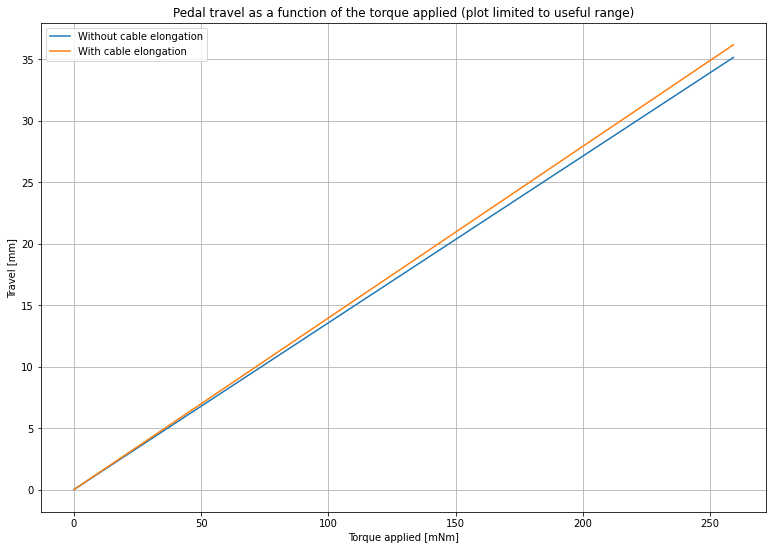

In [10]:
# Plot parameters
F_MIN_TEST = 0
F_MAX_TEST = pedal_total_force
NB_SAMPLE = 100

# System parameters
F = np.linspace(F_MIN_TEST,F_MAX_TEST,NB_SAMPLE) # [N]
reduction = 14 # [ ]
EA_out_radius =  5 # [mm]
cable_length = 500 # [mm]
# Dyneema SK78 3mm
cable_max_load = 14.8*1000 # [N]
cable_elong_at_max_load = 4.2/100 # [ ]
cable_stretch_modulus = cable_max_load / cable_elong_at_max_load # [N] (assumes linear properties)

# Computations
EA_torque_out = F*EA_out_radius # [mNm]
cable_elong = F/cable_stretch_modulus * cable_length
travel = brake_travel*F/F_MAX_TEST + cable_elong # assumes a linear relation between the brake pedal travel and force applied


# Results presentation
print("Maximal values :")
print(f"The needed torque for an out radius of {EA_out_radius} mm is {round(EA_torque_out[NB_SAMPLE-1])} mNm, which is {round(EA_torque_out[NB_SAMPLE-1]/reduction)} mNm at the EA.")
print(f"The output would make {round((brake_travel + cable_elong[NB_SAMPLE-1])/(2*EA_out_radius*np.pi),2)} turn(s) to achieve full range.")
print(f"The cable elongation is {round(cable_elong[NB_SAMPLE-1]/cable_length*100,1)} % ({round(cable_elong[NB_SAMPLE-1],1)} mm) when locking the wheels.")

plt.plot(EA_torque_out/reduction, travel-cable_elong, label='Without cable elongation')
plt.plot(EA_torque_out/reduction, travel, label='With cable elongation')
# plt.vlines(F_MAX_TEST, 0, travel[NB_SAMPLE-1], colors='red', linestyles='dashed', label='Force max')
# plt.hlines(brake_travel, 0, F_MAX_TEST, colors='red', linestyles='dotted', label='Min. pedal travel')

plt.legend(loc="best")
plt.xlabel("Torque applied [mNm]")
plt.ylabel("Travel [mm]")
plt.title("Pedal travel as a function of the torque applied (plot limited to useful range)")
plt.grid()


plt.show()

## EBS
### Materials

In [11]:
UD = {'sigma_max' : 1000, #[MPa]
        'E' : 175*1000, #[MPa]
        'rho' : 1.60/1000, #[g/mm^3]
        'tau_max' : 60, #[MPa]
        'G' : 5*1000 #[MPa]
        }
standard = {'sigma_max' : 600, #[MPa]
        'E' : 70*1000, #[MPa]
        'rho' : 1.60/1000, #[g/mm^3]
        'tau_max' : 90, #[MPa]
        'G' : 5*1000 #[MPa]
        }
aluminium_7075T6 = {'tau_max' : 330, #[MPa]
                    'G' : 26.9*1000, #[MPa]
                    'rho' : 2.70/1000, #[g/mm^3]
                    'E' : 70 *1000, #[MPa]
                    'sigma_max' : 480 #[MPa]
                     }
materials = {'UD' : UD, 'STD' : standard, 'alu' : aluminium_7075T6}

### Flexing beam liked to pedal by a wire
We consider that the wire is attached at the top of the pedal and at the top of the flexing member, and that the forces are colinear with the direction of travel.


#### Parameters
The standard carbon fiber properties come from [here](https://www.azom.com/article.aspx?ArticleID=1995).

In [12]:
# Safety Factor
SF = 1.5 #[ ]

F = pedal_total_force #[N]

# Cable parameters
cable_length = 700 # [mm]
# Dyneema SK78 3mm
cable_max_load = 14.8*1000 # [N]
cable_elong_at_max_load = 4.2/100 # [ ]
# # Zylon Z12 3mm
# cable_max_load = 14.6*1000 # [N]
# cable_elong_at_max_load = 2.7/100 # [ ]
cable_stretch_modulus = cable_max_load / cable_elong_at_max_load # [N] (assumes linear properties)
print(1000/cable_stretch_modulus)

0.002837837837837838


#### Functions

In [13]:
data_template = {
    "F": 0,             # Force in the spring
    "w": 0,             # Spring deflection
    "cable_elong": 0,   # Cable elongation due to tension
    "travel": 0         # Pedal travel
}

result_template = {
    "bottom" : data_template,
    "breaking" : data_template,
    "relation" : data_template
}

def beam_h_linear_decrease(h1, h2, b, l, F_bottom, travel_required):
    '''
    Computes the flexion of a beam with linear thickness decrease.
    
    Params :
    h1 : maximal thickness
    h2 : minimal thickness
    b : width
    l : length
    F_bottom : force requiered at the bottom of the spring travel
    travel_required : travel needed, for bottom to top
    '''
    result = []
    
    m = (h1-h2)/l #[ ] slope of the beam

    # samples to find max strain
    NB_SAMPLE_X = 1000
    x = np.linspace(1,l,NB_SAMPLE_X) 

    for mx in materials:
        result.append(result_template.copy())
        
        # travel at the bottom of the pedal travel
        bottom = data_template.copy()
        bottom["F"] = F_bottom
        C1 = (2*m*l+h2)/(2*m**2*(m*l+h2)**2) # border condition: beam does not change angle at the mount
        C2 = np.log(m*l+h2)/m**3 + h2/(2*m**3*(m*l+h2)) - C1*l # border condition: beam does not change position at the mount
        bottom["w"] = 12*bottom["F"]/(b*materials[mx]['E'])*(-np.log(h2)/m**3 - h2/(2*m**3*(h2)) + C2)
        bottom["cable_elong"] = bottom["F"]/cable_stretch_modulus*cable_length
        bottom["travel"] = bottom["w"] - bottom["cable_elong"]
        result[-1]["bottom"] = bottom

        # force and travel to break spring
        breaking = data_template.copy()
        breaking["F"] = min((materials[mx]['sigma_max']*b*(m*x+h2)**2)/(6*SF*x))
        breaking["w"] = 12*breaking["F"]/(b*materials[mx]['E'])*(-np.log(h2)/m**3 - h2/(2*m**3*(h2)) + C2)
        breaking["cable_elong"] = breaking["F"]/cable_stretch_modulus*cable_length
        breaking["travel"] = breaking["w"] - breaking["cable_elong"]
        result[-1]["breaking"] = breaking

        # force to travel relation
        relation = data_template.copy()
        F_MIN_TEST = 0
        F_MAX_TEST = breaking["F"]*1.2
        NB_SAMPLE_F = 200

        relation["F"] = np.linspace(F_MIN_TEST,F_MAX_TEST,NB_SAMPLE_F) # [N]
        relation["w"] = 12*relation["F"]/(b*materials[mx]['E'])*(-np.log(h2)/m**3-h2/(2*m**3*(h2))+C2)
        relation["cable_elong"] = relation["F"]/cable_stretch_modulus*cable_length
        relation["travel"] = relation["w"] - relation["cable_elong"] # assumes a linear relation between the brake pedal travel and force applied
        result[-1]["relation"] = relation
    
    return result


def beam_standard(h, b, l, F_bottom, travel_required):
    '''
    Computes the flexion of a standard prismatic beam with linear thickness decrease.
    
    Params :
    h : thickness
    b : width
    l : length
    F_bottom : force requiered at the bottom of the spring travel
    travel_required : travel needed, for bottom to top
    '''
    result = []
    
    for mx in materials:
        result.append(result_template.copy())
        
        k = materials[mx]['E']*b*h**3/(4*l**3) # [N/mm] rigidity ot the beam

        # travel at the bottom of the pedal travel
        bottom = data_template.copy()
        bottom["F"] = F_bottom
        bottom["w"] = bottom["F"]/k
        bottom["cable_elong"] = bottom["F"]/cable_stretch_modulus*cable_length
        bottom["travel"] = bottom["w"] - bottom["cable_elong"]
        result[-1]["bottom"] = bottom    

        # force and travel to break spring
        breaking = data_template.copy()
        breaking["F"] = (materials[mx]['sigma_max']*b*h**2)/(6*l*SF)
        breaking["w"] =  breaking["F"]/k
        breaking["cable_elong"] = breaking["F"]/cable_stretch_modulus*cable_length
        breaking["travel"] = breaking["w"] - breaking["cable_elong"]
        result[-1]["breaking"] = breaking

        # force to travel relation
        relation = data_template.copy()
        F_MIN_TEST = 0
        F_MAX_TEST = breaking["F"]*1.2
        NB_SAMPLE_F = 200

        relation["F"] = np.linspace(F_MIN_TEST,F_MAX_TEST,NB_SAMPLE_F) # [N]
        relation["w"] =  relation["F"]/k
        relation["cable_elong"] = relation["F"]/cable_stretch_modulus*cable_length
        relation["travel"] = relation["w"] - relation["cable_elong"] # assumes a linear relation between the brake pedal travel and force applied
        result[-1]["relation"] = relation
    
    return result

In [14]:
def display_beam_plot(result, travel_required):
    '''
    Plot the results from the beam computation.
    '''
    colors = ['purple', 'orange', 'green']
    i = 0
    for mx in materials:
        # force deflextion relation
        plt.plot(result[i]["relation"]["F"], result[i]["relation"]["travel"], label='Pedal tip '+mx, linewidth=3, color=colors[i])
        plt.plot(result[i]["relation"]["F"], result[i]["relation"]["w"], label='Spring tip '+mx, color=colors[i])

        # breaking points
        plt.scatter([result[i]["breaking"]["F"], result[i]["breaking"]["F"]], [result[i]["breaking"]["travel"], result[i]["breaking"]["w"]], marker="+", color='red', s=200, label='Spring breaks '+mx)
    
        # indication lines
        plt.hlines(travel_required+result[i]["bottom"]["travel"], 0, result[i]["relation"]["F"][-1], colors=colors[i], linestyles='dashed', label='Travel for no braking')
        plt.hlines(result[i]["bottom"]["travel"], 0, result[i]["relation"]["F"][-1], colors='black', linestyles='dotted', label='Travel for locking the wheels')
        
        i += 1
    
    plt.vlines(result[1]["bottom"]["F"], 0, result[1]["relation"]["travel"][-1], colors='black', linestyles='dotted', label='Force for locking the wheels')
    
    # legend etc
    plt.legend(loc="best")
    plt.xlabel("Force applied [N]")
    plt.ylabel("Travel [mm]")
    plt.title("Part travel as a function of the force applied")
    plt.grid()


    plt.show()

#### Beam with linear thickness decrease
(the two following simulations are coherent !)

Some good sets of parameters (SF = 1.5):

h1 = 12
h2 = 4
b = 45
l = 400
Long but low forces

h1 = 12
h2 = 4
b = 85
l = 300
Short but high forces

Some good sets of parameters (SF = 2):

h1 = 15
h2 = 6
b = 65
l = 450

The spring would weight 705.6 g.
1194.6666666666667
60.0


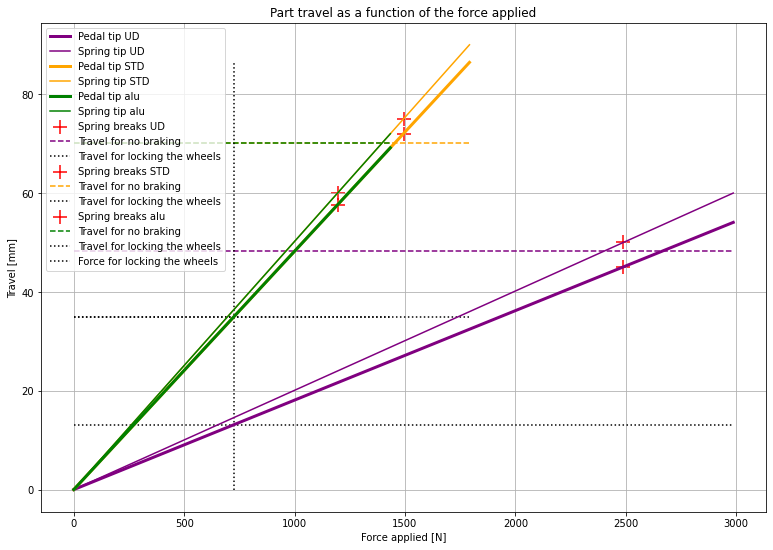

In [15]:
h1 = 14 #[mm] thickest point
h2 = 14 #[mm] thinnest point
b = 60 #[mm] width
l = 525 #[mm] length

F_bottom = F
travel_required = brake_travel

# Compute beam flection
# result = beam_h_linear_decrease(h1, h2, b, l, F_bottom, travel_required)
result = beam_standard(h1, b, l, F_bottom, travel_required)
    
# Result presentation
print(f"The spring would weight {round(materials['STD']['rho']*b*l*(h1+h2)/2,1)} g.")
#print(f"The max strain is situated {round(np.argmin((sigma_max*b*(m*x+h2)**2)/(6*SF*x))*l/NB_SAMPLE_X)} mm from the tip.")
print(result[2]['breaking']['F'])
print(result[2]['breaking']['w'])

display_beam_plot(result, travel_required)

#### Bows in serie
Allows to have no torque applied on the support, and can put many in serie to have more displacement.

Computation is done for a half bow. The result is the extrapolated.

Two good options (SF = 2)
* N = 4, b = 40, l = 160, h1 = 7, h_dim = 3   => 573.4 g
* N = 2, b = 40, l = 270, h1 = 9, h_dim = 3   => 622.1 g

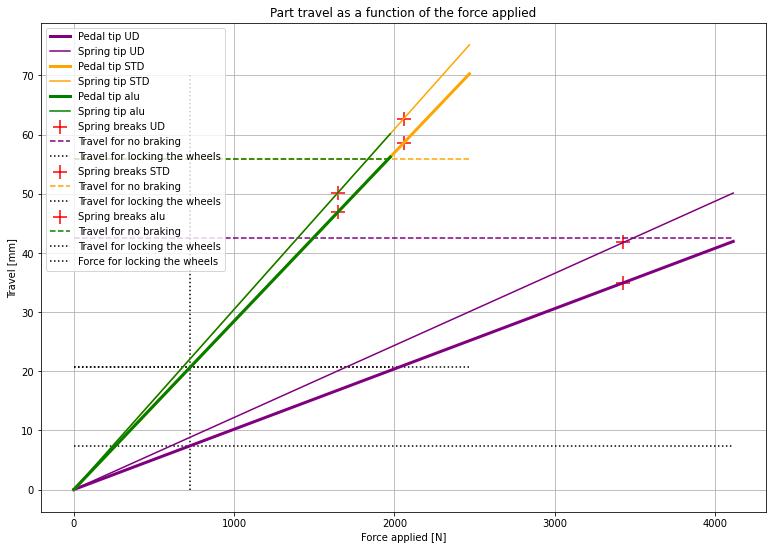

The spring would weight 501.8 g.
2057.1428749126917
62.63738927512955


In [16]:
N = 4 #[ ] (number of bows in serie)
b = 30 #[mm] (width of one bow)
l = 140 #[mm] (length of a half bow)
h = 9 # [mm] (thickness of the bow)
h_dim = 3 # [ ] (diminution factor)

F_bottom = F/2
travel_required = brake_travel/N

# Compute beam flection
result = beam_h_linear_decrease(h, h/h_dim, b, l, F_bottom, travel_required)
# result = beam_standard(h, b, l, F_bottom, travel_required)
    
# # Result presentation
# print(f"The {N} bows would weight {round(rho*b*l*h*N*2,1)} g in total.")
# print(f"\nABSOLUTE MAXIMUMS (SF = 1):\nFor a 3 point flexion test, the bow would break at {round(2*result['breaking']['F']*SF)} N.")
# print(f"The travel would be {round(result['breaking']['w']*SF)} mm.")

# Adjusting the values to have the plot for the whole system
# - Doubling the force because force in the cable is 2* force in the half bow
# - Multiplying the deflextion by N because N half bows are in serie
for i in range(len(materials)):
    for title in result[i]:
        data = result[i][title]
        data["F"] *= 2
        data["w"] *= N
        data["cable_elong"] = data["F"]/cable_stretch_modulus*cable_length
        data["travel"] = data["w"] - data["cable_elong"]
        result[i][title] = data

display_beam_plot(result, brake_travel)
print(f"The spring would weight {round(N*2*materials['STD']['rho']*b*l*(h1+h1/h_dim)/2,1)} g.")
print(result[1]['breaking']['F'])
print(result[1]['breaking']['w'])

### Pneumatic reservoir and piston
A reservoir would contain some pressurized air. A normally open valve placed at the end of the reservoir would link it to the piston. [Here](https://www.viaircorp.com/air-tanks/05gallon) is a example of a 0.5 gallon air tank. It weight 2 kg and measures D = 152.5 mm, L = 146 mm

res = reservoir ; pis = piston

In [17]:
res_V = 0.5 * 4546092 #[mm^3] factor is to convert from galons
pis_D = 40 #[mm]
line_V = np.pi * 1000 * 5**2 / 4 #[mm^3]
F = pedal_total_force #[N]
x = brake_travel #[mm]
P_start = 1 #[MPa]

pis_A = np.pi * pis_D**2 / 4
# One time EBS
P_open = F / pis_A
V_open = res_V + line_V + x*pis_A
P_close = P_open * V_open / res_V

# How much time EBS
N = np.log(P_start/P_open) / np.log(V_open/res_V)

print(f"The tank need to be pressurized at > {round(P_close*10,1)} bars = {round(P_close/0.006894757,1)} psi.")
print("The max allowed pressure is 10 bars. (Rule T 9.1.1)")
print(f"The pressure lost at each activation of the EBS is {round((P_close-P_open)*10,2)} bars = {round((P_close-P_open)/0.006894757,1)} psi.")
print(f"With an initial pressure of {P_start*10} bars, the EBS can be run {N//1} times")

The tank need to be pressurized at > 5.9 bars = 86.1 psi.
The max allowed pressure is 10 bars. (Rule T 9.1.1)
The pressure lost at each activation of the EBS is 0.16 bars = 2.4 psi.
With an initial pressure of 10 bars, the EBS can be run 19.0 times


### Torsion bar
[Shear stess from tensile stress](https://roymech.org/Useful_Tables/Matter/shear_tensile.html)

[Alu alloys properties](https://www.engineeringtoolbox.com/properties-aluminum-pipe-d_1340.html)

[Alu 7075-T6](https://matmatch.com/learn/material/7075-t6-aluminium)

[Torsion of rectangle beam](https://engineeringlibrary.org/reference/beam-torsion-air-force-stress-manual)

#### Round bar + rectangle flex

In [18]:
bar_mx = materials['STD']
bar_lever_mx = materials['STD']
bar_length = 400 # [mm]
bar_D = 30 # [mm] diamètre extérieur
bar_d = 15 # [mm] diamètre intérieur
bar_lever_l = 150 # [mm] length
bar_lever_w = 50 # [mm] width
bar_lever_t = 10 # [mm] thickness

travel_required = brake_travel
min_force_required = pedal_total_force

print(f"travel = {round(brake_travel)} mm")
print(f"travel_a = {round((brake_travel/(bar_lever_l))*180/math.pi,1)}°")
print(f"force = {round(pedal_total_force)} N\n")

# Required forces etc
k_bar_angular = bar_mx['G']*math.pi*(bar_D**4-bar_d**4)/(32*bar_length)
k_bar_lever = bar_lever_mx['E']*bar_lever_w*bar_lever_t**3/(4*bar_lever_l**3)
k_linear = k_bar_angular/(bar_lever_l**2) * k_bar_lever/(k_bar_angular/(bar_lever_l**2) + k_bar_lever)

F_at_max_travel = min_force_required + travel_required*k_linear
M_at_max_travel = F_at_max_travel*bar_lever_l

print(f"ka_bar = {round(k_bar_angular)} Nmm/rad")
print(f"k_lame = {round(k_bar_lever)} N/mm")
print(f"k = {round(k_linear)} N/mm")
print(f"F_max_travel = {round(F_at_max_travel)} N")
print(f"M_max_travel = {round(M_at_max_travel/1000)} Nm")



# Check if it deforms plastically
M_max = bar_mx['tau_max']*math.pi*(bar_D**4-bar_d**4)/(16*bar_D)
F_max = bar_lever_mx['sigma_max']*bar_lever_w*bar_lever_t**2/(6*bar_lever_l)

print(f"\nM_max = {round(M_max/1000)} Nm")
print(f"Actual max M is {round(M_at_max_travel/M_max*100,1)}% of M_max.")

print(f"F_max = {round(F_max)} N")
print(f"Actual max F is {round(F_at_max_travel/F_max*100,1)}% of F_max.")

print(f"Actual w_max = {round(F_at_max_travel/k_linear,1)} mm")

print(f"\nSF ~= {round(min(F_max/F_at_max_travel, M_max/M_at_max_travel),2)}.")

# Compute the weight of the system
m_bar = bar_length*(bar_D**2-bar_d**2)*math.pi*bar_mx['rho']
m_bar_lever = bar_lever_l*bar_lever_t*bar_lever_w*bar_lever_mx['rho']

print(f"\n\nThe total mass is {round(m_bar+m_bar_lever)} g.")

travel = 35 mm
travel_a = 13.4°
force = 725 N

ka_bar = 931893 Nmm/rad
k_lame = 259 N/mm
k = 36 N/mm
F_max_travel = 1981 N
M_max_travel = 297 Nm

M_max = 447 Nm
Actual max M is 66.4% of M_max.
F_max = 3333 N
Actual max F is 59.4% of F_max.
Actual w_max = 55.5 mm

SF ~= 1.51.


The total mass is 1477 g.


#### L shape

In [19]:
bar_mx = materials['STD']
bar_lever_mx = materials['STD']
bar_l = 400 # [mm]
bar_w = 40 # [mm] width
bar_t = 15 # [mm] thickness
bar_lever_l = 100 # [mm] length
bar_lever_w = 15 # [mm] width
bar_lever_t = 40 # [mm] thickness


travel_required = brake_travel
min_force_required = pedal_total_force

print(f"travel = {round(brake_travel)} mm")
print(f"travel_a = {round((brake_travel/(bar_lever_l))*180/math.pi,1)}°")
print(f"force = {round(pedal_total_force)} N\n")

# Required forces etc
beta = (1-0.63*bar_t/bar_w*(1-bar_t**4/bar_w**4/12))/3
k_bar_angular = bar_mx['G']*bar_w*bar_t**3*beta/(3*bar_l)
k_bar_lever = bar_lever_mx['E']*bar_lever_w*bar_lever_t**3/(4*bar_lever_l**3)
k_linear = k_bar_angular/(bar_lever_l**2) * k_bar_lever/(k_bar_angular/(bar_lever_l**2) + k_bar_lever)

F_at_max_travel = min_force_required + travel_required*k_linear
M_at_max_travel = F_at_max_travel*bar_lever_l

print(f"ka_bar = {round(k_bar_angular)} Nmm/rad")
print(f"k_lame = {round(k_bar_lever)} N/mm")
print(f"k = {round(k_linear)} N/mm")
print(f"F_max_travel = {round(F_at_max_travel)} N")
print(f"M_max_travel = {round(M_at_max_travel/1000)} Nm")



# Check if it deforms plastically
alpha = 1/(3 + 1.8*bar_t/bar_w)
M_max = bar_mx['tau_max']*alpha*bar_w*bar_t**2
F_max = bar_lever_mx['sigma_max']*bar_lever_w*bar_lever_t**2/(6*bar_lever_l)

print(f"\nM_max = {round(M_max/1000)} Nm")
print(f"Actual max M is {round(M_at_max_travel/M_max*100,1)}% of M_max.")

print(f"F_max = {round(F_max)} N")
print(f"Actual max F is {round(F_at_max_travel/F_max*100,1)}% of F_max.")

print(f"Actual w_max = {round(F_at_max_travel/k_linear,1)} mm")

print(f"\nSF ~= {round(min(F_max/F_at_max_travel, M_max/M_at_max_travel),2)}.")


# Compute the weight of the system
m_bar = bar_l*bar_t*bar_w*bar_mx['rho']
m_bar_lever = bar_lever_l*bar_lever_t*bar_lever_w*bar_lever_mx['rho']

print(f"\n\nThe total mass is {round(m_bar+m_bar_lever)} g.")

travel = 35 mm
travel_a = 20.1°
force = 725 N

ka_bar = 143276 Nmm/rad
k_lame = 16800 N/mm
k = 14 N/mm
F_max_travel = 1229 N
M_max_travel = 123 Nm

M_max = 220 Nm
Actual max M is 55.7% of M_max.
F_max = 24000 N
Actual max F is 5.1% of F_max.
Actual w_max = 85.8 mm

SF ~= 1.79.


The total mass is 480 g.


### Retention mechanism
#### Parameters

In [36]:
frict_coef = 0.1
force_preload = 2370 # [N]

#### Simple cotter pin

In [37]:
F_release = frict_coef * force_preload

print(f"The force required to pull the pin is about {round(F_release,1)} N.")

The force required to pull the pin is about 237.0 N.


#### Crossbow trigger
For the dimensions meaning, please refer to the picture.

In [40]:
# parameters
AB = 100 # [mm]
BC = 20 # [mm]
CD = 70 # [mm]
DE = 20 # [mm]
ABC = 90 # [°]
CDE = 70 # [°]
shaft_diam = 6 # [mm]


# release force estimation
CDE = np.deg2rad(CDE)
T_shaftB = shaft_diam*force_preload*frict_coef * (DE/CD) * np.cos(CDE)
F_release = force_preload*frict_coef * (DE/CD) * (BC/AB) * np.cos(CDE) + T_shaftB/AB

# print result
print(f"The force required to release the trigger is about {round(F_release,2)} N.")
print(f"It would be about {round(max(BC,DE)*1.6)} x {round((AB+CD)*1.1)} mm.")

The force required to release the trigger is about 6.02 N.
It would be about 32 x 187 mm.


In [39]:
# To inspect element
print(force_preload/F_release)

393.5890538681078


# Component selection
## SB actuator
We have 4 options that fulfill the force criterion :
* [NEMA 17](https://en.nanotec.com/products/376-st4118l3004-b) with [reduction](https://en.nanotec.com/products/2727-gp42-s2-15-sr) and [encoder](https://en.nanotec.com/products/243-weds5541-b14-5-mm)
* [NEMA 23](https://en.nanotec.com/products/2778-sca5618l4204-a2) with [reduction](https://en.nanotec.com/products/2683-gp56-s1-3-sr)
* [NEMA 34](https://en.nanotec.com/products/574-st8918m6708-a)
* [Linear actuator](https://www.ato.com/mini-linear-actuator)

Respective variables have the prefix N1, N2, N3, L.

In [24]:
N = 15.4 # reduction ratio
T_max = 550 # [Nmm] max torque 
v_at_T_max = 600/60*2*np.pi # [rad/s]

max_r = N*T_max/pedal_total_force # [mm]
v_long = v_at_T_max*T_max/pedal_total_force # [mm/s]

print(f"Maximal pulley radius is {round(max_r,1)} mm.")
print(f"It gives a cable speed of {round(v_long)} mm/s.")
print(f"The maximal output torque is {round(T_max*N)} Nmm.")

Maximal pulley radius is 11.7 mm.
It gives a cable speed of 48 mm/s.
The maximal output torque is 8470 Nmm.


### Actuators data

In [25]:
base_temp = 40 # [°C] (assuming a very hot day)
max_temp = 100 # [°C]
copper_specific_heat = 390 # [J/(kg*°C)]

# ----- NEMA 17 -----
N1_reduction = 15.45 # [ ]
N1_max_torque = 0.531 # [Nm]
N1_lever = 1000*N1_max_torque*N1_reduction/pedal_total_force # [mm]
N1_speed_max_load = 450 # [rpm]
N1_mass = 0.34 # [kg]
N1_current = 3 # [A]
N1_portion_that_heats = 0.5 # [ ]
N1_resistance = 0.63*2 # [Ohm] (3 Ohms, 2 windings)
N1_step = 1.8 # [°]



# ----- NEMA 23 -----
N2_reduction = 3.29 # [ ]
N2_max_torque = 1.9 # [Nm]
N2_lever = 1000*N2_max_torque/pedal_total_force # [mm]
N2_speed_max_load = 190 # [rpm]
N2_mass = 1.1 # [kg]
N2_current = 4.2 # [A]
N2_portion_that_heats = 0.5 # [ ]
N2_resistance = 0.55*2 # [Ohm] (3 Ohms, 2 windings)
N2_step = 1.8 # [°]


# ----- N3 -----
N3_reduction = 1 # [ ]
N3_max_torque = 6.15 # [Nm]
N3_lever = 1000*N3_max_torque/pedal_total_force # [mm]
N3_speed_max_load = 37.5 # [rpm]
N3_mass = 2.8 # [kg]
N3_current = 6.7 # [A]
N3_portion_that_heats = 0.5 # [ ]
N3_resistance = 0.45*4 # [Ohm] (3 Ohms, 4 windings)
N3_step = 1.8 # [°]

# ----- L -----
L_speed_no_load = 11.1 # [mm/s]
L_speed_max_load = 8.9 # [mm/s]
L_max_load = 850 # [N]
L_mass = 3 # [kg]
L_current = 4.7 # [A]
L_portion_that_heats = 0.1 # [ ]

In [26]:
print(N3_lever)

8.477357763743218


### Time from 0 to Locked wheels
We assume that the force on the pedal is linear with the travel, and that te relation between L_speed and load is linear.

In [27]:
# ----- N1 -----
N1_time_0_to_lock = brake_travel / (N1_speed_max_load/N1_reduction * np.pi/30 * N1_lever)
print(N1_time_0_to_lock)

# ----- N2 -----
N2_time_0_to_lock = brake_travel / (N2_speed_max_load/N2_reduction * np.pi/30 * N2_lever)
print(N2_time_0_to_lock)

# ----- N3 -----
N3_time_0_to_lock = brake_travel / (N3_speed_max_load/N3_reduction * np.pi/30 * N3_lever)
print(N3_time_0_to_lock)

# ----- L -----
# L_speed_lock_wheel = (L_speed_max_load-L_speed_no_load) * pedal_total_force /L_max_load + L_speed_no_load

# m = (L_speed_lock_wheel-L_speed_no_load)/brake_travel
# h = L_speed_no_load

# L_time_0_to_lock = 1/m * np.log(m*brake_travel/h + 1)
L_time_0_to_lock = brake_travel / L_speed_max_load
print(L_time_0_to_lock)

1.0191962885438315
2.2194918998765503
1.0559867887156575
3.9499252383441807


### Resolution
Resolution is the minimum increment of pressure in the brake line achievable.

In [28]:
# ----- N1 -----
N1_res_dist = N1_lever * N1_step * np.pi/180 / N1_reduction # [mm]
N1_res_force = N1_res_dist * pedal_total_force / brake_travel
N1_res_press = N1_res_force / pedal_total_force * pression_locking_R
print(N1_res_press)

# ----- N2 -----
N2_res_dist = N2_lever * N2_step * np.pi/180 / N2_reduction # [mm]
N2_res_force = N2_res_dist * pedal_total_force / brake_travel
N2_res_press = N2_res_force / pedal_total_force * pression_locking_R
print(N2_res_press)

# ----- N3 -----
N3_res_dist = N3_lever * N3_step * np.pi/180 # [mm]
N3_res_force = N3_res_dist * pedal_total_force / brake_travel
N3_res_press = N3_res_force / pedal_total_force * pression_locking_R
print(N3_res_press)

# ----- L -----
# No data


# ATTENTION C'EST EN MPa = 10 bar

0.004251716163060747
0.004624102433222526
0.049243040306635774


### Heating

In [29]:
# ----- N1 -----
N1_power = N1_resistance * N1_current**2

N1_max_time_continuous_use = N1_portion_that_heats*N1_mass * copper_specific_heat * (max_temp - base_temp) / N1_power
print(N1_max_time_continuous_use)

# ----- N2 -----
N2_power = N2_resistance * N2_current**2

N2_max_time_continuous_use = N2_portion_that_heats*N2_mass * copper_specific_heat * (max_temp - base_temp) / N2_power
print(N2_max_time_continuous_use)

# ----- N3 -----
N3_power = N3_resistance * N3_current**2

N3_max_time_continuous_use = N3_portion_that_heats*N3_mass * copper_specific_heat * (max_temp - base_temp) / N3_power
print(N3_max_time_continuous_use)

# ----- L -----
# Assume 10% of the total weight is what is heated (motor is small compared to actuator), made of copper, 
# and all power goes to heating
L_power = L_current*24 # 24 V

L_max_time_continuous_use = L_portion_that_heats*L_mass * copper_specific_heat * (max_temp - base_temp) / L_power
print(L_max_time_continuous_use)

350.7936507936509
663.2653061224489
405.43550902205385
62.23404255319149


## Cables
The cable selected for the applications are Dyneema SK78 3mm. 

## Pulleys
The selection depends on the cable diameter and bending flexibility. More infos on how to choose a pulley [here](https://www.savacable.com/how-to-choose-the-right-mechanical-cable-pulleys).